In [2]:
# Dependencies
import gmaps
import numpy as np
import pandas as pd
import requests
import time
from scipy.stats import linregress
from matplotlib import pyplot as plt

In [3]:
unclean_wildfire_df = pd.read_csv('NOAA_csvs/wildfires_2010_2019.csv')

In [4]:
unclean_wildfire_df.columns

Index(['EVENT_ID', 'CZ_NAME_STR', 'BEGIN_LOCATION', 'BEGIN_DATE', 'BEGIN_TIME',
       'EVENT_TYPE', 'MAGNITUDE', 'TOR_F_SCALE', 'DEATHS_DIRECT',
       'INJURIES_DIRECT', 'DAMAGE_PROPERTY_NUM', 'DAMAGE_CROPS_NUM',
       'STATE_ABBR', 'CZ_TIMEZONE', 'MAGNITUDE_TYPE', 'EPISODE_ID', 'CZ_TYPE',
       'CZ_FIPS', 'WFO', 'INJURIES_INDIRECT', 'DEATHS_INDIRECT', 'SOURCE',
       'FLOOD_CAUSE', 'TOR_LENGTH', 'TOR_WIDTH', 'BEGIN_RANGE',
       'BEGIN_AZIMUTH', 'END_RANGE', 'END_AZIMUTH', 'END_LOCATION',
       'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON', 'EVENT_NARRATIVE',
       'EPISODE_NARRATIVE', 'ABSOLUTE_ROWNUMBER'],
      dtype='object')

In [5]:
reduce_wildfire = unclean_wildfire_df[['EVENT_ID', 'CZ_NAME_STR', 'BEGIN_DATE', 'DEATHS_DIRECT', 'DEATHS_INDIRECT', 'INJURIES_DIRECT', 'INJURIES_INDIRECT', 
                                  'DAMAGE_PROPERTY_NUM', 'DAMAGE_CROPS_NUM', 'CZ_FIPS',]]
reduce_wildfire = reduce_wildfire.rename(columns={'EVENT_ID': 'NOAA ID', 
                                                'CZ_NAME_STR':'County_Name', 
                                                'BEGIN_DATE': 'Date', 
                                                'DEATHS_DIRECT': 'Direct_Deaths',
                                                'DEATHS_INDIRECT': 'Indirect_Deaths',
                                                'INJURIES_DIRECT': 'Direct_Injuries',
                                                'INJURIES_INDIRECT': 'Indirect_Injuries',
                                                'DAMAGE_PROPERTY_NUM': 'Property_Damage', 
                                                'DAMAGE_CROPS_NUM': 'Crop_Damage', 
                                                'CZ_FIPS': 'County_FIPS', 
                                                })
reduce_wildfire
reduce_wildfire['Date'] = reduce_wildfire['Date'].replace('/', ' ', regex=True).astype('string')
reduce_wildfire['Date'] = reduce_wildfire['Date'].str.slice(start=6)
reduce_wildfire['County_Name'] = reduce_wildfire['County_Name'].str.rstrip(' (ZONE)')
reduce_wildfire['County_Name'].value_counts()

WESTERN SISKIYOU COUNTY                                           32
SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - THE INLAND EMPIR    30
S SIERRA MTNS                                                     25
KERN CTY MTNS                                                     24
S SIERRA FOOTHILLS                                                22
                                                                  ..
SOUTHERN SALINAS VALLEY / ARROYO SECO / LAKE SAN ANTONI            1
LOS ANGELES COUNTY COASTS INCLUDING DOWNTOWN LOS ANGELES           1
WEST CENTRAL SAN JOAQUIN VALLEY                                    1
GREATER LAKE TAHOE AREA                                            1
NORTH CENTRAL & SOUTHEAST SISKIYOU COUNTY                          1
Name: County_Name, Length: 74, dtype: int64

In [62]:
reduce_wildfire.head(100)

,NOAA ID,County_Name,Date,Direct_Deaths,Indirect_Deaths,Direct_Injuries,Indirect_Injuries,Property_Damage,Crop_Damage,County_FIPS
0,234746,SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...,2010,0,0,0,1,0,0,48
1,250167,SAN DIEGO COUNTY COASTAL AREAS,2010,0,0,0,0,0,0,43
2,250175,SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...,2010,0,0,1,0,17500,0,48
3,250169,RIVERSIDE COUNTY MOUNTAINS,2010,0,0,0,0,0,0,56
4,250171,SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...,2010,0,0,0,0,0,0,48
...,...,...,...,...,...,...,...,...,...,...
95,475340,SANTA LUCIA MOUNTAINS AND LOS PADRES NATIONAL ...,2013,0,0,0,0,0,0,517
96,510087,TULARE CTY MTNS,2013,0,0,0,0,0,0,97
97,510089,S SIERRA MTNS,2013,0,0,0,0,0,0,96
98,469817,WESTERN SISKIYOU COUNTY,2013,0,0,0,0,0,0,80


In [7]:
reduce_wildfire['Date'].value_counts()

2014    59
2017    59
2019    56
2013    42
2016    41
2018    40
2015    34
2010    24
2012    22
2011    21
Name: Date, dtype: Int64

In [8]:
reduce_wildfire['Direct_Deaths'].value_counts()

0     372
1      10
2       7
3       5
4       2
86      1
8       1
Name: Direct_Deaths, dtype: int64

In [9]:
reduce_wildfire['Indirect_Deaths'].value_counts()

0    391
1      6
2      1
Name: Indirect_Deaths, dtype: int64

In [10]:
reduce_wildfire['Direct_Injuries'].value_counts()

0     341
1      13
2       8
4       7
3       7
5       5
6       4
8       3
19      2
12      2
9       2
21      1
18      1
10      1
7       1
Name: Direct_Injuries, dtype: int64

In [11]:
reduce_wildfire['Indirect_Injuries'].value_counts()

0     370
3       8
1       7
4       4
2       3
12      2
10      1
9       1
6       1
5       1
Name: Indirect_Injuries, dtype: int64

In [12]:
reduce_wildfire['Property_Damage'].value_counts()

0              320
500000           7
100000           6
1000000          5
5000             5
200000           4
400000           4
600000           3
50000            3
4000000          2
25000            2
6000             2
2000000          2
900000           2
22500000         1
250000           1
15000            1
50000000         1
7240000          1
550000           1
35000            1
17500            1
8000000          1
4500000          1
38400000         1
20000000         1
15000000         1
1500000000       1
20000            1
1000             1
5700000          1
56000000         1
7000000          1
4000             1
30000000         1
1500000          1
2500000          1
10000000         1
17000000000      1
25000000         1
8000             1
30000            1
3670000          1
1120000          1
10000            1
Name: Property_Damage, dtype: int64

In [13]:
reduce_wildfire['Crop_Damage'].value_counts()

0       397
5000      1
Name: Crop_Damage, dtype: int64

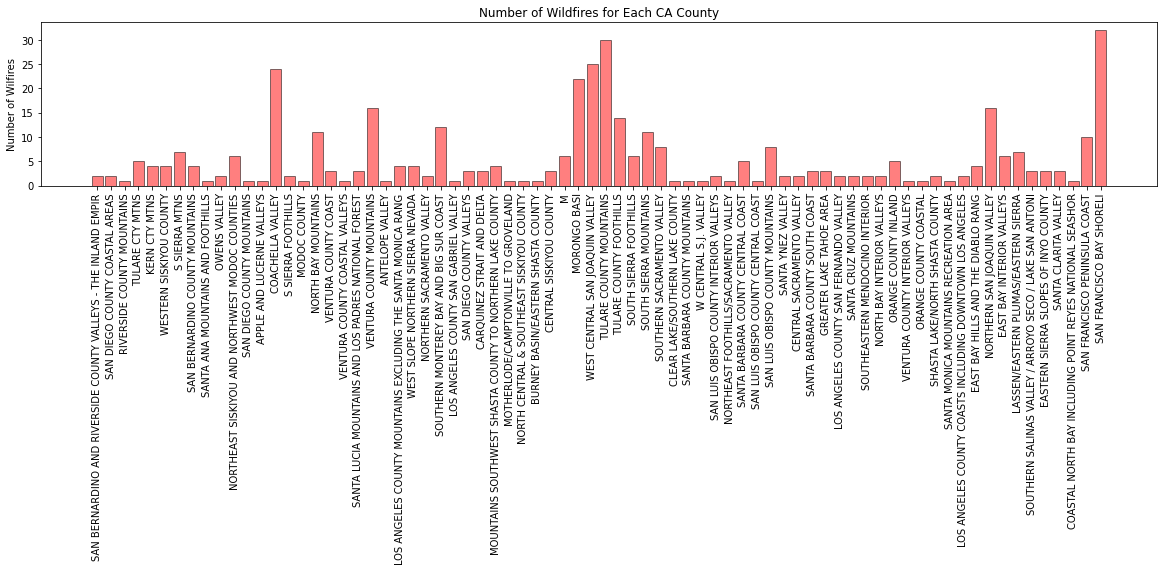

In [112]:
counties = reduce_wildfire.groupby(reduce_wildfire['County_Name'])
county = reduce_wildfire['County_Name'].unique()
county_count = counties['County_Name'].count()
tick_loc = [value for value in county]
plt.figure(figsize=(20,3))
plt.bar(county, county_count, color='r', alpha=0.5, align="center", edgecolor='black')
plt.xticks(tick_loc, county, rotation='vertical')
plt.title('Number of Wildfires for Each CA County')
plt.ylabel('Number of Wilfires')
plt.show()

In [142]:
property_wildfire = reduce_wildfire.loc[(reduce_wildfire['Property_Damage'] > 0)]
property_wildfire = property_wildfire[['County_FIPS', 'Date', 'County_Name', 'Property_Damage']]
property_wildfire.to_csv('wildfire_property_damage.csv', encoding='utf-8', index=False)
property_wildfire.head(100)

,County_FIPS,Date,County_Name,Property_Damage
2,48,2010,SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...,17500
5,48,2010,SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...,8000
22,95,2010,KERN CTY MTNS,250000
23,57,2010,SANTA ANA MOUNTAINS AND FOOTHILLS,400000
24,520,2011,OWENS VALLEY,4500000
...,...,...,...,...
365,48,2019,SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...,100000
376,50,2019,SAN DIEGO COUNTY VALLEYS,50000
385,48,2019,SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...,100000
387,48,2019,SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...,100000


In [101]:
wildfire_2010 = property_wildfire.loc[(property_wildfire['Date'] == '2010')]
wildfire_2010 = wildfire_2010[['County_FIPS','County_Name', 'Property_Damage']]
wildfire_2010 = wildfire_2010.sort_values(by=['Property_Damage'])
wildfire_2010.head(25)

,County_FIPS,County_Name,Property_Damage
5,48,SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...,8000
2,48,SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...,17500
22,95,KERN CTY MTNS,250000
23,57,SANTA ANA MOUNTAINS AND FOOTHILLS,400000


In [77]:
# county_2010 =  wildfire_2010.groupby('County_Name')
# pdamage_2010 = pd.DataFrame(county_2010['Property_Damage'].value_counts())
# pdamage_2010 = pdamage_2010.rename(columns={'Property_Damage': 'PD_Count'})
# pdamage_2010 = pdamage_2010.reset_index()
# pdamage_2010 = pdamage_2010[['County_Name', 'Property_Damage']]
# pdamage_2010.head(25)

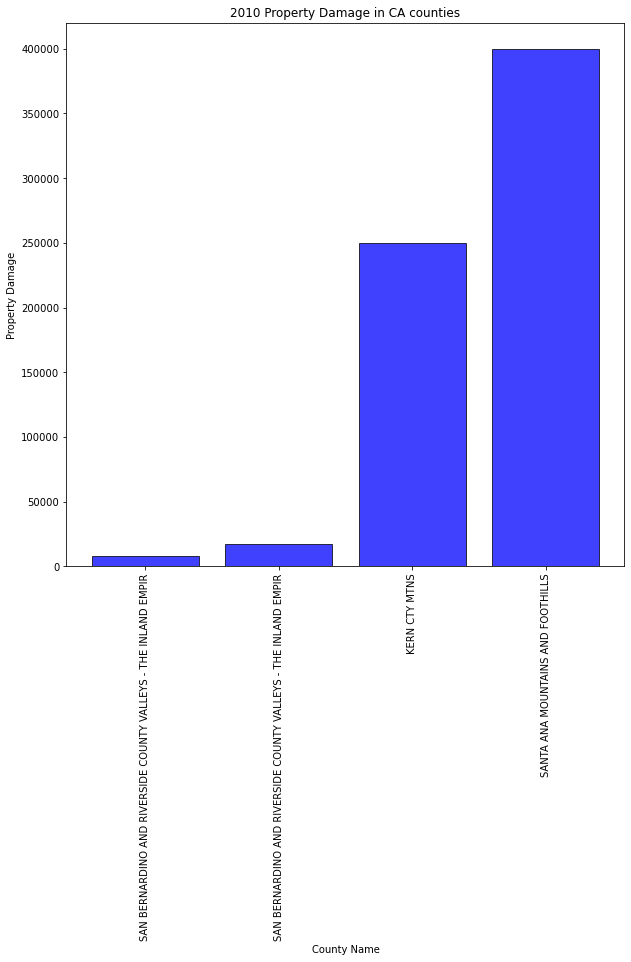

In [133]:
x_axis = np.arange(len(wildfire_2010))
p_tick_loc = [value+0.4 for value in x_axis]
                         
plt.figure(figsize=(10,10))
plt.bar(x_axis , wildfire_2010['Property_Damage'], color='b', alpha=0.75, align='edge', edgecolor='black')
plt.xticks(p_tick_loc, wildfire_2010['County_Name'], rotation='vertical')

plt.title('2010 Property Damage in CA counties')
plt.xlabel('County Name')
plt.ylabel('Property Damage')
plt.savefig('Chia_pngs/wildfires_2010', dpi=300, bbox_inches='tight')
plt.show()

In [102]:
wildfire_2011 = property_wildfire.loc[(property_wildfire['Date'] == '2011')]
wildfire_2011 = wildfire_2011[['County_FIPS','County_Name', 'Property_Damage']]
wildfire_2011 = wildfire_2011.sort_values(by=['Property_Damage'])
wildfire_2011.head(25)

,County_FIPS,County_Name,Property_Damage
26,58,SAN DIEGO COUNTY MOUNTAINS,25000
31,55,SAN BERNARDINO COUNTY MOUNTAINS,500000
35,60,APPLE AND LUCERNE VALLEYS,600000
24,520,OWENS VALLEY,4500000
36,95,KERN CTY MTNS,10000000


In [76]:
# county_2011 =  wildfire_2011.groupby('County_Name')
# pdamage_2011 = pd.DataFrame(county_2011['Property_Damage'].value_counts())
# pdamage_2011 = pdamage_2011.rename(columns={'Property_Damage': 'PD_Count'})
# pdamage_2011 = pdamage_2011.reset_index()
# pdamage_2011 = pdamage_2011[['County_Name', 'Property_Damage']]
# pdamage_2011.head(25)

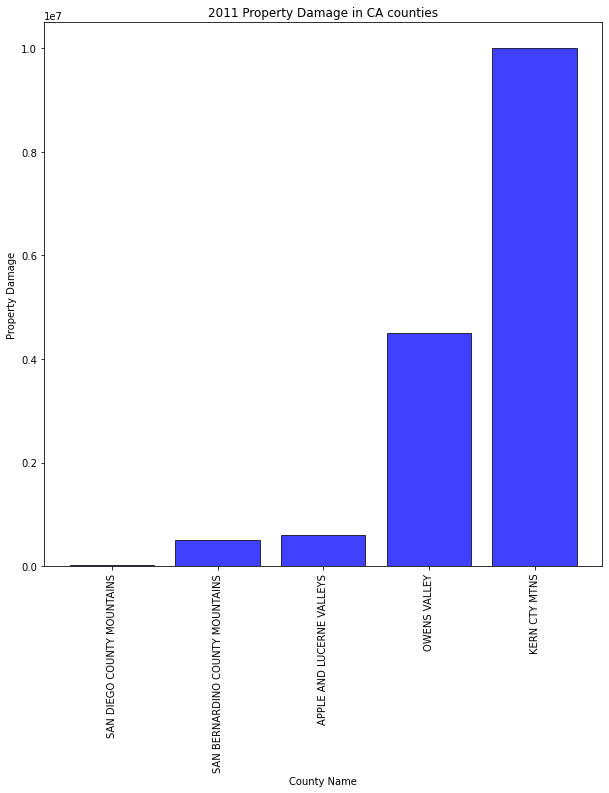

In [131]:
x_axis = np.arange(len(wildfire_2011))
# y_axis = np.arange(len(pd))
px_tick_loc = [value+0.4 for value in x_axis]


plt.figure(figsize=(10,10))
plt.bar(x_axis , wildfire_2011['Property_Damage'], color='b', alpha=0.75, align='edge', edgecolor='black')

plt.xticks(px_tick_loc, wildfire_2011['County_Name'], rotation='vertical')

plt.title('2011 Property Damage in CA counties')
plt.xlabel('County Name')
plt.ylabel('Property Damage')
plt.savefig('Chia_pngs/wildfires_2011', dpi=300, bbox_inches='tight')
plt.show()

In [104]:
wildfire_2012 = property_wildfire.loc[(reduce_wildfire['Date'] == '2012')]
wildfire_2012 = wildfire_2012[['County_FIPS','County_Name', 'Property_Damage']]
wildfire_2012 = wildfire_2012.sort_values(by=['Property_Damage'])
wildfire_2012.head(25)

,County_FIPS,County_Name,Property_Damage
66,55,SAN BERNARDINO COUNTY MOUNTAINS,4000
45,55,SAN BERNARDINO COUNTY MOUNTAINS,20000
53,95,KERN CTY MTNS,200000
55,48,SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...,200000
50,58,SAN DIEGO COUNTY MOUNTAINS,400000
59,56,RIVERSIDE COUNTY MOUNTAINS,1000000
65,58,SAN DIEGO COUNTY MOUNTAINS,3670000


In [84]:
# county_2012 =  wildfire_2012.groupby('County_Name')
# pdamage_2012 = pd.DataFrame(county_2012['Property_Damage'].value_counts())
# pdamage_2012 = pdamage_2012.rename(columns={'Property_Damage': 'PD_Count'})
# pdamage_2012 = pdamage_2012.reset_index()
# pdamage_2012 = pdamage_2012[['County_Name', 'Property_Damage']]
# pdamage_2012.head(25)

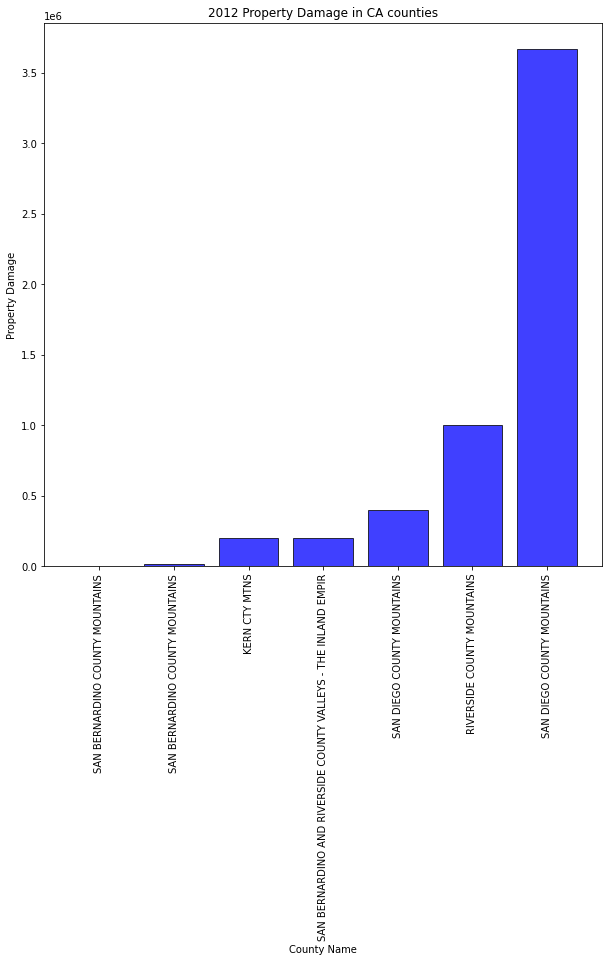

In [132]:
x_axis = np.arange(len(wildfire_2012))
p_tick_loc = [value+0.4 for value in x_axis]
                         
plt.figure(figsize=(10,10))
plt.bar(x_axis , wildfire_2012['Property_Damage'], color='b', alpha=0.75, align='edge', edgecolor='black')
plt.xticks(p_tick_loc, wildfire_2012['County_Name'], rotation='vertical')

plt.title('2012 Property Damage in CA counties')
plt.xlabel('County Name')
plt.ylabel('Property Damage')
plt.savefig('Chia_pngs/wildfires_2012', dpi=300, bbox_inches='tight')
plt.show()

In [105]:
wildfire_2013 = property_wildfire.loc[(reduce_wildfire['Date'] == '2013')]
wildfire_2013 = wildfire_2013[['County_FIPS','County_Name', 'Property_Damage']]
wildfire_2013 = wildfire_2013.sort_values(by=['Property_Damage'])
wildfire_2013.head(25)

,County_FIPS,County_Name,Property_Damage
89,57,SANTA ANA MOUNTAINS AND FOOTHILLS,5000
107,507,NORTH BAY MOUNTAINS,5000
106,43,SAN DIEGO COUNTY COASTAL AREAS,10000
67,48,SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...,15000
81,55,SAN BERNARDINO COUNTY MOUNTAINS,50000
69,48,SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...,400000
68,507,NORTH BAY MOUNTAINS,500000
72,48,SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...,550000
83,56,RIVERSIDE COUNTY MOUNTAINS,2000000
90,56,RIVERSIDE COUNTY MOUNTAINS,7000000


In [89]:
# county_2013 =  wildfire_2013.groupby('County_Name')
# pdamage_2013 = pd.DataFrame(county_2013['Property_Damage'].value_counts())
# pdamage_2013 = pdamage_2013.rename(columns={'Property_Damage': 'PD_Count'})
# pdamage_2013 = pdamage_2013.reset_index()
# pdamage_2013 = pdamage_2013[['County_Name', 'Property_Damage']]
# pdamage_2013.head(25)

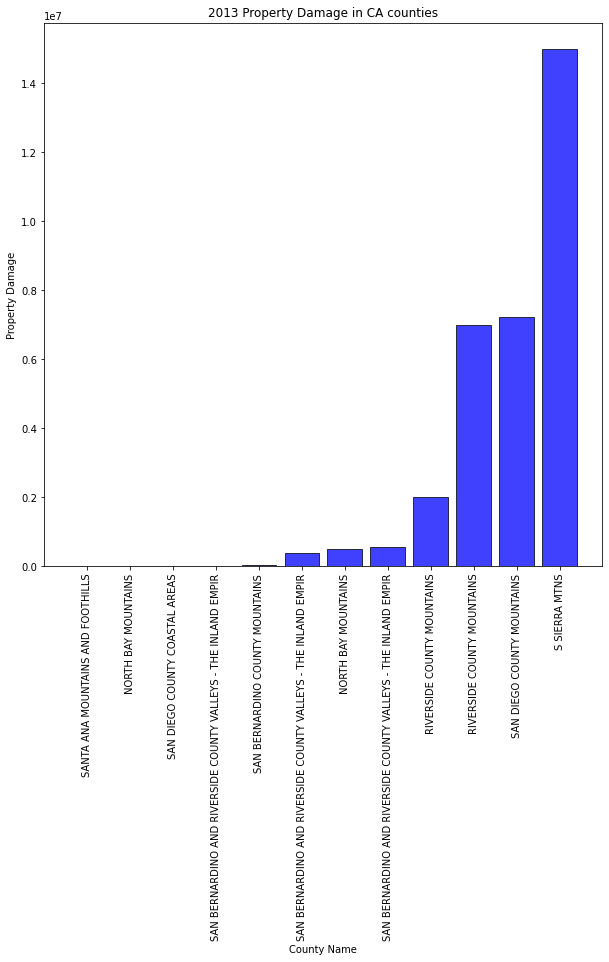

In [128]:
x_axis = np.arange(len(wildfire_2013))
p_tick_loc = [value+0.4 for value in x_axis]
                         
plt.figure(figsize=(10,10))
plt.bar(x_axis , wildfire_2013['Property_Damage'], color='b', alpha=0.75, align='edge', edgecolor='black')
plt.xticks(p_tick_loc, wildfire_2013['County_Name'], rotation='vertical')

plt.title('2013 Property Damage in CA counties')
plt.xlabel('County Name')
plt.ylabel('Property Damage')
plt.savefig('Chia_pngs/wildfires_2013', dpi=300, bbox_inches='tight')
plt.show()

In [106]:
wildfire_2014 = property_wildfire.loc[(reduce_wildfire['Date'] == '2014')]
wildfire_2014 = wildfire_2014[['County_FIPS','County_Name', 'Property_Damage']]
wildfire_2014 = wildfire_2014.sort_values(by=['Property_Damage'])
wildfire_2014.head(25)

,County_FIPS,County_Name,Property_Damage
163,57,SANTA ANA MOUNTAINS AND FOOTHILLS,5000
113,48,SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...,6000
114,48,SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...,6000
112,61,COACHELLA VALLEY,35000
154,80,WESTERN SISKIYOU COUNTY,200000
148,80,WESTERN SISKIYOU COUNTY,600000
160,80,WESTERN SISKIYOU COUNTY,600000
129,58,SAN DIEGO COUNTY MOUNTAINS,900000
124,93,S SIERRA FOOTHILLS,1000000
126,93,S SIERRA FOOTHILLS,1000000


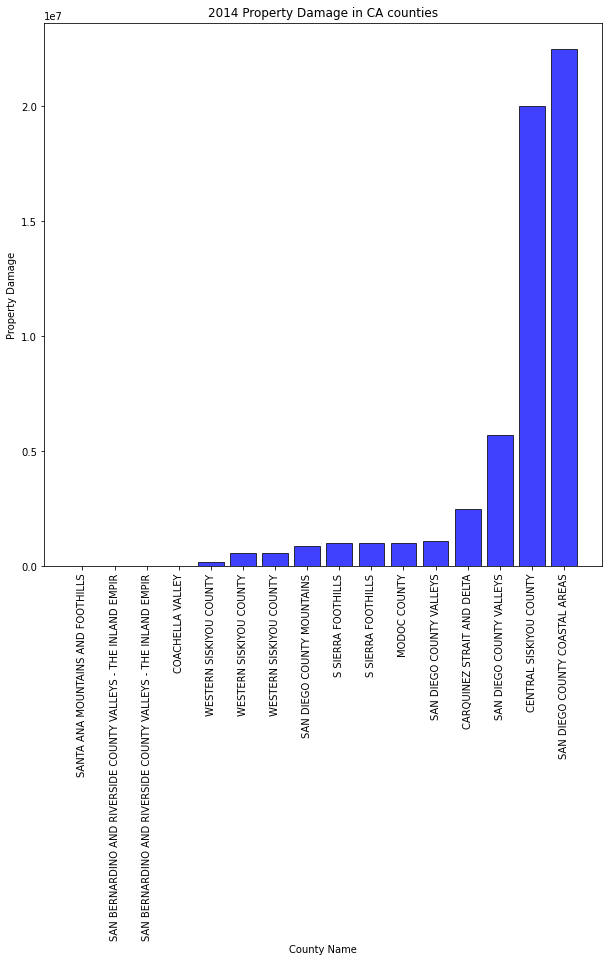

In [134]:
x_axis = np.arange(len(wildfire_2014))
p_tick_loc = [value+0.4 for value in x_axis]
                         
plt.figure(figsize=(10,10))
plt.bar(x_axis , wildfire_2014['Property_Damage'], color='b', alpha=0.75, align='edge', edgecolor='black')
plt.xticks(p_tick_loc, wildfire_2014['County_Name'], rotation='vertical')

plt.title('2014 Property Damage in CA counties')
plt.xlabel('County Name')
plt.ylabel('Property Damage')
plt.savefig('Chia_pngs/wildfires_2014', dpi=300, bbox_inches='tight')
plt.show()

In [118]:
wildfire_2015 = property_wildfire.loc[(reduce_wildfire['Date'] == '2015')]
wildfire_2015 = wildfire_2015[['County_FIPS','County_Name', 'Property_Damage']]
wildfire_2015 = wildfire_2015.sort_values(by=['Property_Damage'])
wildfire_2015.head(25)

,County_FIPS,County_Name,Property_Damage
168,520,OWENS VALLEY,1000
179,69,WEST SLOPE NORTHERN SIERRA NEVADA,25000
170,525,MORONGO BASI,30000
174,55,SAN BERNARDINO COUNTY MOUNTAINS,500000
184,17,SOUTHERN SACRAMENTO VALLEY,500000
171,55,SAN BERNARDINO COUNTY MOUNTAINS,900000


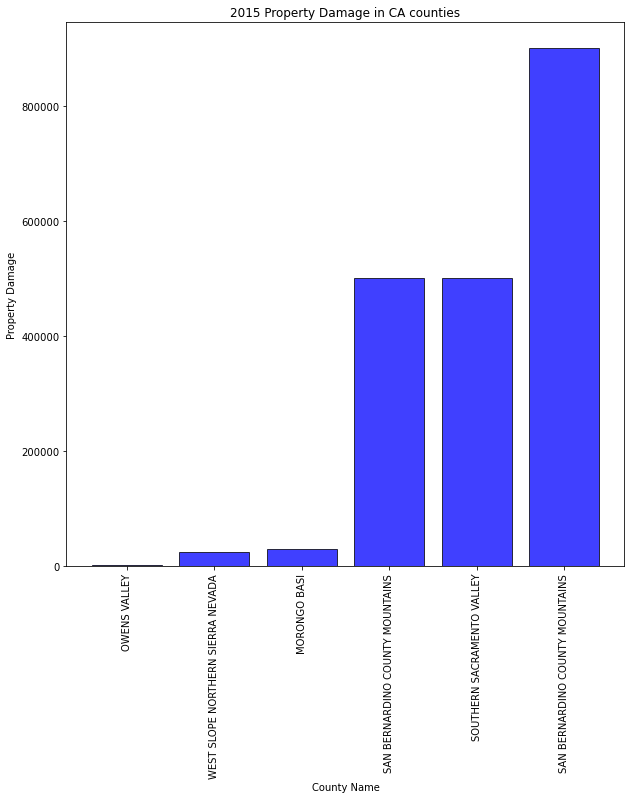

In [135]:
x_axis = np.arange(len(wildfire_2015))
p_tick_loc = [value+0.4 for value in x_axis]
                         
plt.figure(figsize=(10,10))
plt.bar(x_axis , wildfire_2015['Property_Damage'], color='b', alpha=0.75, align='edge', edgecolor='black')
plt.xticks(p_tick_loc, wildfire_2015['County_Name'], rotation='vertical')

plt.title('2015 Property Damage in CA counties')
plt.xlabel('County Name')
plt.ylabel('Property Damage')
plt.savefig('Chia_pngs/wildfires_2015', dpi=300, bbox_inches='tight')
plt.show()

In [120]:
wildfire_2016 = property_wildfire.loc[(reduce_wildfire['Date'] == '2016')]
wildfire_2016 = wildfire_2016[['County_FIPS','County_Name', 'Property_Damage']]
wildfire_2016 = wildfire_2016.sort_values(by=['Property_Damage'])
wildfire_2016.head(25)

,County_FIPS,County_Name,Property_Damage
218,48,SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...,50000
227,64,CLEAR LAKE/SOUTHERN LAKE COUNTY,1500000
205,50,SAN DIEGO COUNTY VALLEYS,4000000
228,55,SAN BERNARDINO COUNTY MOUNTAINS,50000000


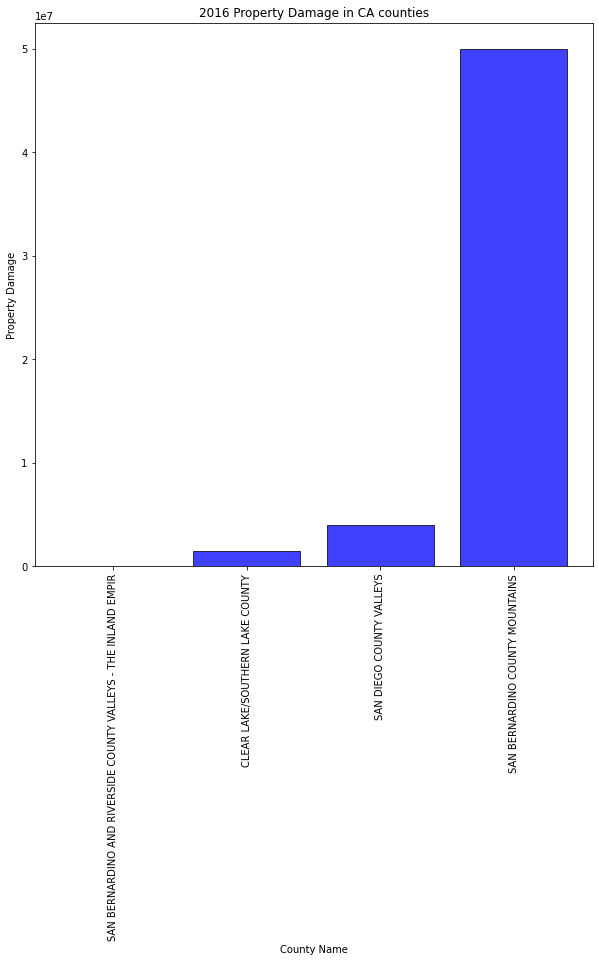

In [136]:
x_axis = np.arange(len(wildfire_2016))
p_tick_loc = [value+0.4 for value in x_axis]
                         
plt.figure(figsize=(10,10))
plt.bar(x_axis , wildfire_2016['Property_Damage'], color='b', alpha=0.75, align='edge', edgecolor='black')
plt.xticks(p_tick_loc, wildfire_2016['County_Name'], rotation='vertical')

plt.title('2016 Property Damage in CA counties')
plt.xlabel('County Name')
plt.ylabel('Property Damage')
plt.savefig('Chia_pngs/wildfires_2016', dpi=300, bbox_inches='tight')
plt.show()

In [122]:
wildfire_2017 = property_wildfire.loc[(reduce_wildfire['Date'] == '2017')]
wildfire_2017 = wildfire_2017[['County_FIPS','County_Name', 'Property_Damage']]
wildfire_2017 = wildfire_2017.sort_values(by=['Property_Damage'])
wildfire_2017.head(25)

,County_FIPS,County_Name,Property_Damage
286,57,SANTA ANA MOUNTAINS AND FOOTHILLS,1000000
285,18,CARQUINEZ STRAIT AND DELTA,2000000
295,554,ORANGE COUNTY INLAND,25000000
301,50,SAN DIEGO COUNTY VALLEYS,30000000
287,113,SOUTHEASTERN MENDOCINO INTERIOR,38400000


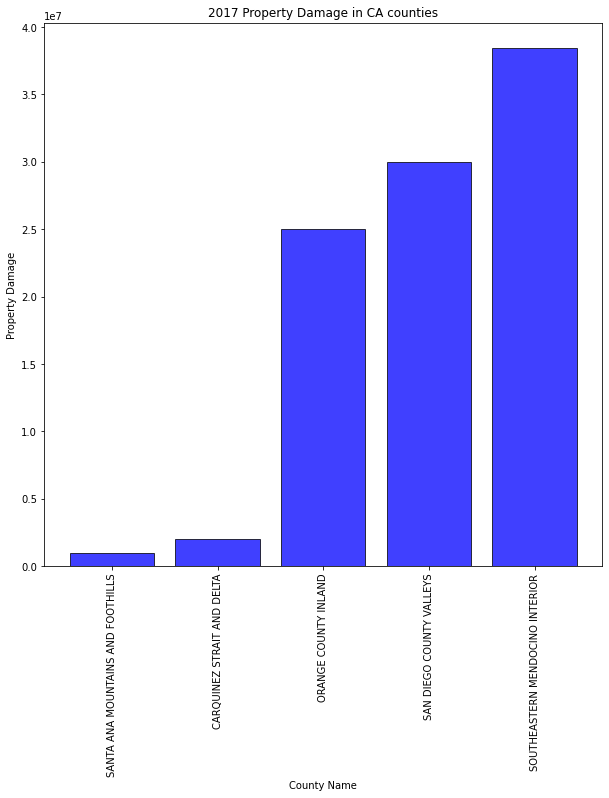

In [137]:
x_axis = np.arange(len(wildfire_2017))
p_tick_loc = [value+0.4 for value in x_axis]
                         
plt.figure(figsize=(10,10))
plt.bar(x_axis , wildfire_2017['Property_Damage'], color='b', alpha=0.75, align='edge', edgecolor='black')
plt.xticks(p_tick_loc, wildfire_2017['County_Name'], rotation='vertical')

plt.title('2017 Property Damage in CA counties')
plt.xlabel('County Name')
plt.ylabel('Property Damage')
plt.savefig('Chia_pngs/wildfires_2017', dpi=300, bbox_inches='tight')
plt.show()

In [124]:
wildfire_2018 = property_wildfire.loc[(reduce_wildfire['Date'] == '2018')]
wildfire_2018 = wildfire_2018[['County_FIPS','County_Name', 'Property_Damage']]
wildfire_2018 = wildfire_2018.sort_values(by=['Property_Damage'])
wildfire_2018.head(25)

,County_FIPS,County_Name,Property_Damage
308,61,COACHELLA VALLEY,100000
318,56,RIVERSIDE COUNTY MOUNTAINS,200000
312,58,SAN DIEGO COUNTY MOUNTAINS,500000
316,61,COACHELLA VALLEY,500000
328,57,SANTA ANA MOUNTAINS AND FOOTHILLS,500000
319,63,MOUNTAINS SOUTHWEST SHASTA COUNTY TO NORTHERN ...,56000000
317,15,NORTHERN SACRAMENTO VALLEY,1500000000
334,66,NORTHEAST FOOTHILLS/SACRAMENTO VALLEY,17000000000


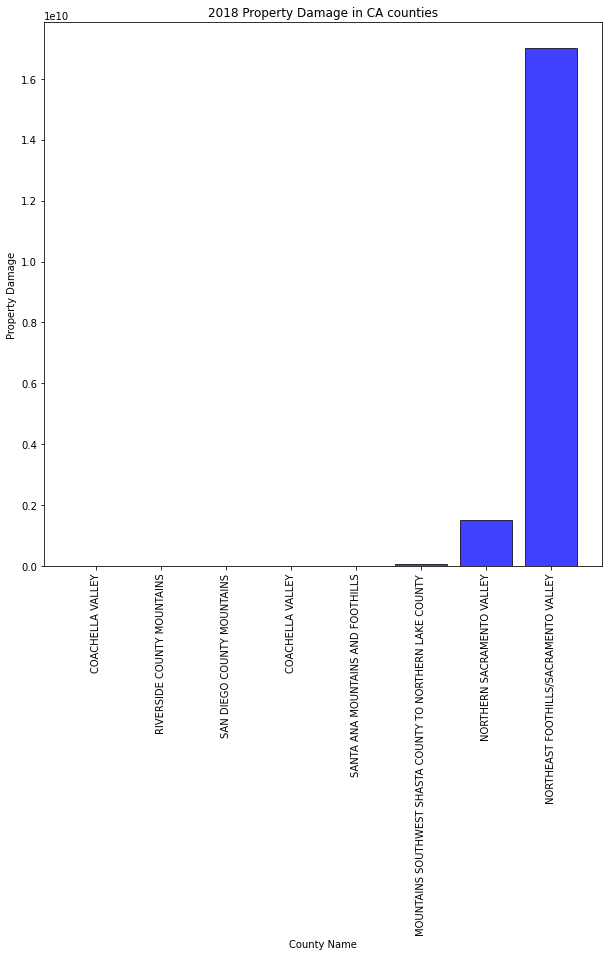

In [138]:
x_axis = np.arange(len(wildfire_2018))
p_tick_loc = [value+0.4 for value in x_axis]
                         
plt.figure(figsize=(10,10))
plt.bar(x_axis , wildfire_2018['Property_Damage'], color='b', alpha=0.75, align='edge', edgecolor='black')
plt.xticks(p_tick_loc, wildfire_2018['County_Name'], rotation='vertical')

plt.title('2018 Property Damage in CA counties')
plt.xlabel('County Name')
plt.ylabel('Property Damage')
plt.savefig('Chia_pngs/wildfires_2018', dpi=300, bbox_inches='tight')
plt.show()

In [126]:
wildfire_2019 = property_wildfire.loc[(reduce_wildfire['Date'] == '2019')]
wildfire_2019 = wildfire_2019[['County_FIPS','County_Name', 'Property_Damage']]
wildfire_2019 = wildfire_2019.sort_values(by=['Property_Damage'])
wildfire_2019.head(25)

,County_FIPS,County_Name,Property_Damage
343,511,EAST BAY HILLS AND THE DIABLO RANG,5000
347,510,EAST BAY INTERIOR VALLEYS,5000
376,50,SAN DIEGO COUNTY VALLEYS,50000
353,48,SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...,100000
354,519,EASTERN SIERRA SLOPES OF INYO COUNTY,100000
365,48,SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...,100000
385,48,SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...,100000
387,48,SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...,100000
348,48,SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...,400000
388,48,SAN BERNARDINO AND RIVERSIDE COUNTY VALLEYS - ...,4000000


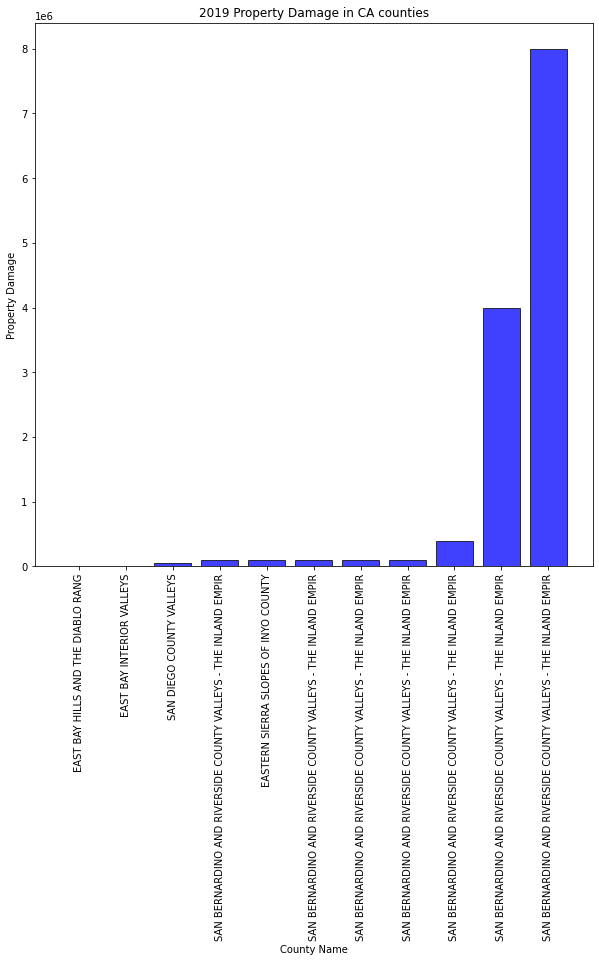

In [139]:
x_axis = np.arange(len(wildfire_2019))
p_tick_loc = [value+0.4 for value in x_axis]
                         
plt.figure(figsize=(10,10))
plt.bar(x_axis , wildfire_2019['Property_Damage'], color='b', alpha=0.75, align='edge', edgecolor='black')
plt.xticks(p_tick_loc, wildfire_2019['County_Name'], rotation='vertical')

plt.title('2019 Property Damage in CA counties')
plt.xlabel('County Name')
plt.ylabel('Property Damage')
plt.savefig('Chia_pngs/wildfires_2019', dpi=300, bbox_inches='tight')
plt.show()